In [317]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import derivative

Общие параметры:

In [337]:
interval_start = -5.
interval_end = 5.
plot_nodes_count = 200

nodes_left_boundary = 4
nodes_right_boundary = 21

figsize_standart = (8, 6)
dpi_standart = 100
linewidth_standart = 1.0
bbox_to_anchor_standart = (1.05, 1)
cmap_name_standart = 'winter'

Функция для нахождения i-го базисного полинома Лагранжа:

In [319]:
def l_i(i, x, x_nodes):
    li = 1
    
    for j in range(len(x_nodes)):
        if j != (i - 1):
            li *= (x - x_nodes[j]) / (x_nodes[i - 1] - x_nodes[j])
    return li

Функция для нахождения интерполяционного полинома Лагранжа

In [320]:
def L(x, x_nodes, y_nodes):
    Lx = 0
    
    for i in range(len(x_nodes)):
        Lx += y_nodes[i] * l_i(i + 1, x, x_nodes)
    return Lx

Функция для кусочно-линейной интерполяции:

In [321]:
def f_piece_lin(x, x_nodes, y_nodes):
    a0 = 0
    a1 = 0
    
    for i in range(1, len(x_nodes)):
        if (x >= x_nodes[i - 1] and x <= x_nodes[i]):
            a1 = (y_nodes[i] - y_nodes[i - 1]) / (x_nodes[i] - x_nodes[i - 1])
            a0 = y_nodes[i - 1] - a1 * x_nodes[i - 1]

            return (a0 + a1 * x_nodes[i - 1])
        
    return None

Заданная функция:

In [322]:
def f(x):
    return np.exp(-x**2)

Вспомогательная функция для пересчета значений оптимальных узлов на произвольном отрезке:

In [323]:
def translate_to_interval(x, start, end):
    return 0.5 * ( (end - start) * x + start + end )

Вспомогательная функция для нахождения производной функции:

In [324]:
def nth_derivative(f, n, x):
    if (n % 2 == 0):
        derivative_order = n + 1
    else:
        derivative_order = n + 2
        
    nth_derivative = derivative(f, x, n=n, order=derivative_order)
    
    return nth_derivative

Вспомогательная функция для нахождения оптимальных узлов:

In [344]:
def cheb_nodes(start, end, n):
    x_cheb = np.array([])
    
    for k in range(n):
        x_cheb = np.append(x_cheb,
                  translate_to_interval(
                    np.cos( (2 * (k + 1) - 1) * np.pi / (2 * n) ),
                    start, end))
    return x_cheb

Функция для нахождения остаточного члена в случае равномерно распределенных узлов:

In [326]:
def rem_evenly(x, x_nodes):
    rem_evenly = 0
    
    n = len(x_nodes)
    
    if 0 not in x:
        x = np.append(x, 0)
        
    nth_derivative_vec = np.vectorize(nth_derivative, excluded=['f', 'n'])
    derivatives_array = nth_derivative(f=f, n=n, x=x)

    rem_evenly = np.max(derivatives_array) / np.math.factorial(n)
    
    interval_middle = interval_start - interval_end
    for i in range(n):
        if (x_nodes[i] >= interval_middle):
            max_x = interval_start
        else:
            max_x = interval_end
        rem_evenly *= (max_x - x_nodes[i])
        
    return rem_evenly

Функция для нахождения остаточного члена в случае равномерно оптимально узлов:

In [327]:
def rem_cheb(x, x_nodes):
    n = len(x_nodes)
    
    nth_derivative_vec = np.vectorize(nth_derivative, excluded=['f', 'n'])
    derivatives_array = nth_derivative(f=f, n=n, x=x)
    
    rem_cheb = np.max(derivatives_array / ( 2**(n - 1) * (np.math.factorial(n))))
    
    return rem_cheb

Функция для нахождения остаточного члена в случае кусочно-линейной интерполяции:

In [328]:
def rem_piece_lin(x, x_nodes):
    n = len(x_nodes)
    
    h = ( interval_start - interval_end ) / (n - 1)
    
    rem_piece_lin = (np.e * h**2) / 8 
        
    return rem_piece_lin

# Построение графиков для равномерно расположенных узлов.

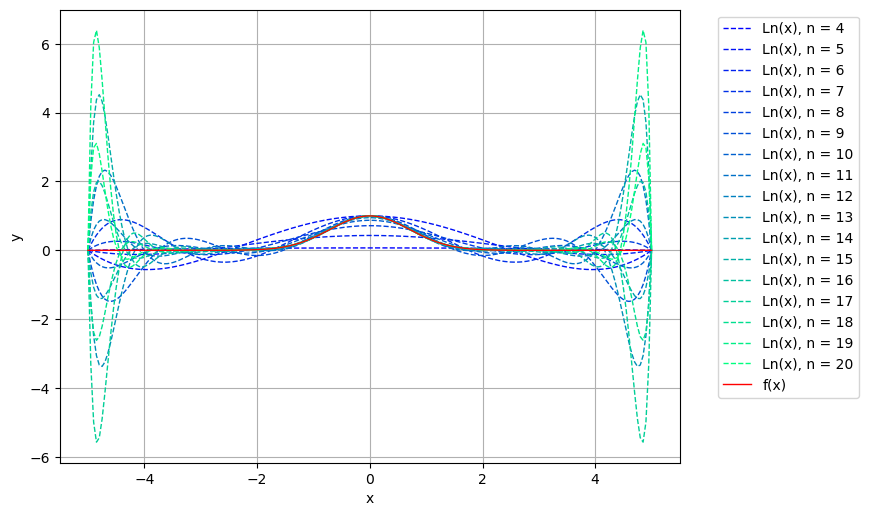

In [342]:
f_vec = np.vectorize(f)
L_vec = np.vectorize(L, excluded=['x_nodes', 'y_nodes'])
f_piece_lin_vec = np.vectorize(f_piece_lin, excluded=['x_nodes', 'y_nodes'])

x = np.linspace(interval_start, interval_end, nodes_count)
fx_vec = f_vec(x)
N = np.arange(nodes_left_boundary, nodes_right_boundary)

cmap = plt.cm.get_cmap(cmap_name_standart, len(N))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    axes.plot(x, L(x, x_nodes_evenly_distributed, f(x_nodes_evenly_distributed)),
              color=cmap(n - nodes_left_boundary), linestyle='--',
              linewidth=linewidth_standart, label='Ln(x), n = {}'.format(n))
    
axes.plot(x, fx, color="red", linewidth=linewidth_standart, label='f(x)')
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

# Нахождение расстояния между заданной функцией и полученным интерполяционным полиномом в лебеговом пространстве.

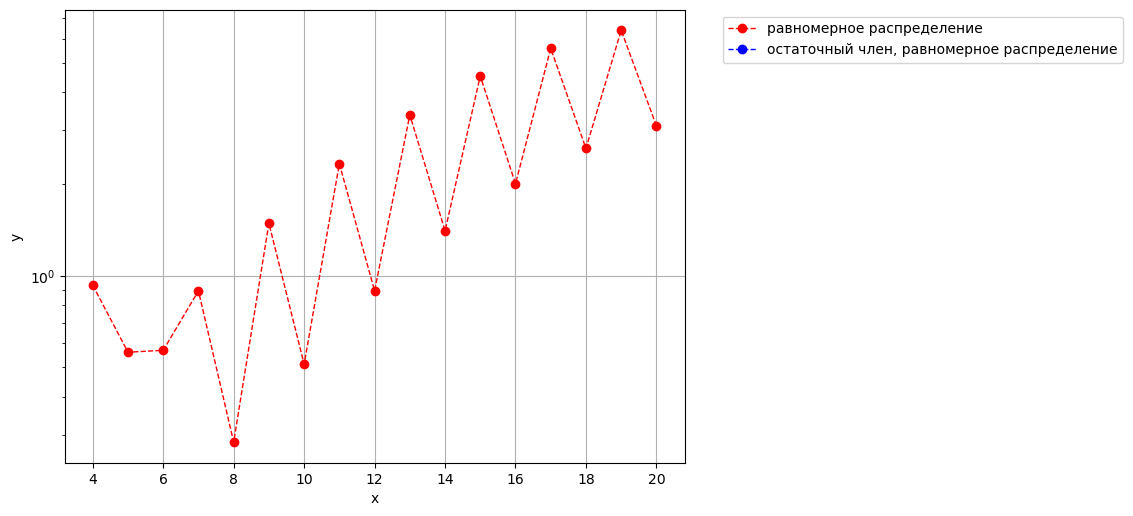

In [346]:
norm_evenly_array = np.array([])
norm_cheb_array = np.array([])
norm_piece_lin_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    x_nodes_cheb = cheb_nodes(interval_start, interval_end, n)
    
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    y_nodes_cheb = f(x_nodes_cheb)
        
    diff_evenly_array = np.abs(fx_vec - L_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed))
    diff_cheb_array = np.abs(fx_vec - L_vec(x=x, x_nodes=x_nodes_cheb,
                                        y_nodes=y_nodes_cheb))
    diff_piece_lin_array = np.abs(fx_vec - f_piece_lin_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed))
    
    norm_evenly_array = np.append(norm_evenly_array, np.max(diff_evenly_array))
    norm_cheb_array = np.append(norm_cheb_array, np.max(diff_cheb_array))
    norm_piece_lin_array = np.append(norm_piece_lin_array, np.max(diff_piece_lin_array))
                       

    
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
axes.semilogy(N, norm_evenly_array, '--o', color="red",
              linewidth=linewidth_standart, label="равномерное распределение")
axes.semilogy(N, rem_evenly_array, '--o', color="blue",
              linewidth=linewidth_standart, label="остаточный член, равномерное распределение")
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

In [347]:
rem_evenly_array = np.array([])
rem_cheb_array = np.array([])
rem_piece_lin_array = np.array([])


rem_evenly_array = np.append(rem_evenly_array, rem_evenly(x, x_nodes_evenly_distributed))
rem_cheb_array = np.append(rem_cheb_array, rem_cheb(x, x_nodes_cheb))
rem_piece_lin_array = np.append(rem_piece_lin_array, rem_piece_lin(x, x_nodes_evenly_distributed))


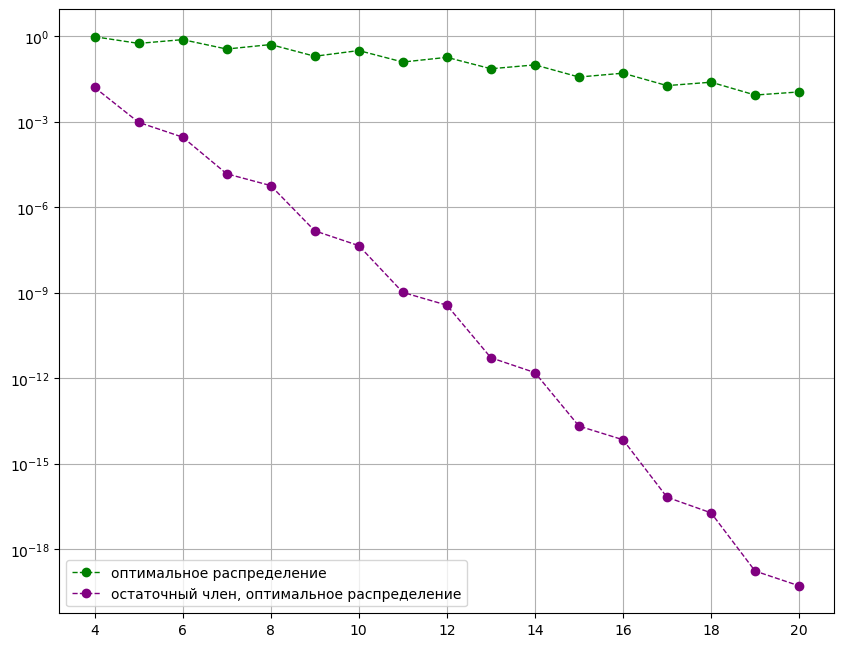

In [306]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
axes.semilogy(N, norm_cheb_array, '--o', color="green",
              linewidth=linewidth_standart, label="оптимальное распределение")
axes.semilogy(N, rem_cheb_array, '--o', color="purple",
              linewidth=linewidth_standart, label="остаточный член, оптимальное распределение")
axes.grid()
axes.legend(loc='lower left')
plt.show()

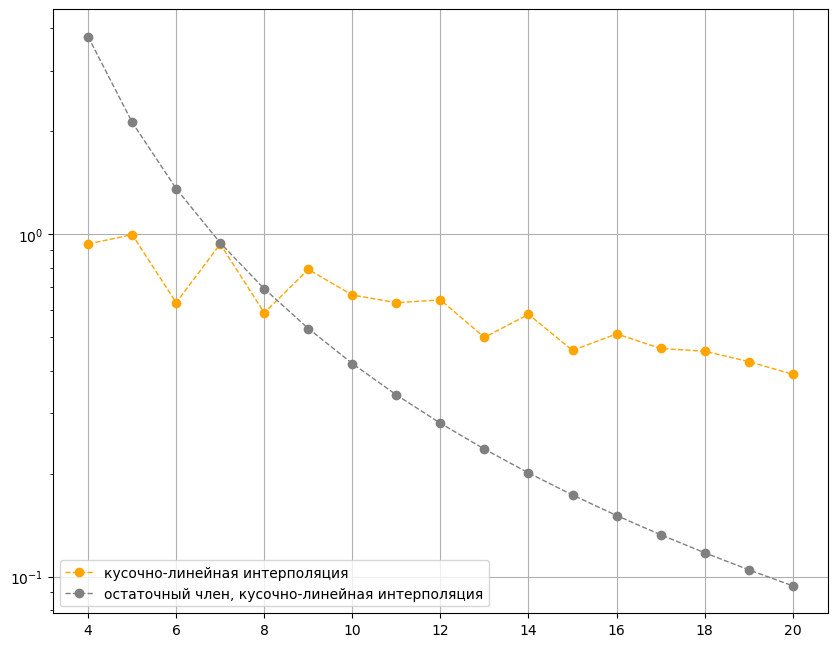

In [307]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
axes.semilogy(N, norm_piece_lin_array, '--o', color="orange",
              linewidth=linewidth_standart, label="кусочно-линейная интерполяция")
axes.semilogy(N, rem_piece_lin_array, '--o', color="grey",
              linewidth=linewidth_standart, label="остаточный член, кусочно-линейная интерполяция")
axes.grid()
axes.legend(loc='lower left')
plt.show()

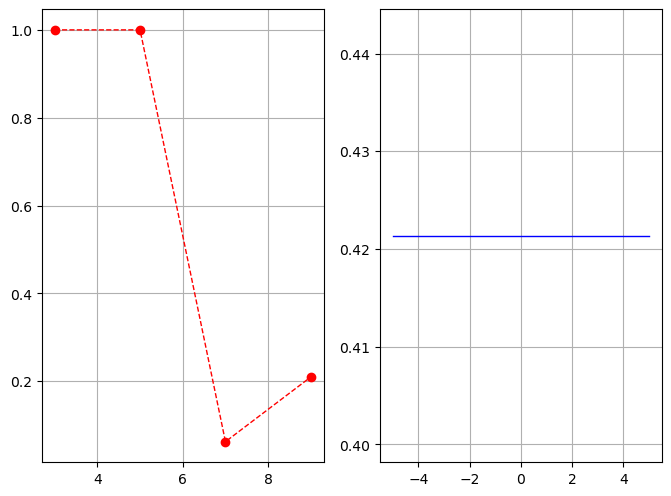

In [308]:
def f_err(x):
    f_lambda = lambda t: np.exp(-t**2)
    
    integral, accuracy = integrate.quad(f_lambda, 0, 1)
    return (1 / np.sqrt(np.pi)) * integral

N = [3, 5, 7, 9]
f_kus_lin_func = []
f_err_func = []

for n in N:
    x_nodes_evenly_distributed = np.linspace(-5., 5., n)
    f_kus_lin_func.append(f_kus_lin(2., x_nodes_evenly_distributed, f(x_nodes_evenly_distributed)))
    
for i in range(len(x)):
    f_err_func.append(f_err(x[i]))
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), dpi=100)

axes[0].plot(N, f_kus_lin_func, '--o', color="red", linewidth=1.0)
axes[1].plot(x, f_err_func, color="blue", linewidth=1.0)

axes[0].grid()
axes[1].grid()

plt.show()